In [11]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from torch.utils.data import DataLoader, TensorDataset

In [12]:
#!pip install imblearn
# Check for CUDA availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [13]:
# Load Dataset
file_path = "predictive_maintenance.csv"
df = pd.read_csv(file_path)

In [8]:
# Display dataset information
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Target                   10000 non-null  int64  
 9   Failure Type             10000 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 781.4+ KB


(None,
    UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
 0    1     M14860    M                298.1                    308.6   
 1    2     L47181    L                298.2                    308.7   
 2    3     L47182    L                298.1                    308.5   
 3    4     L47183    L                298.2                    308.6   
 4    5     L47184    L                298.2                    308.7   
 
    Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target Failure Type  
 0                    1551         42.8                0       0   No Failure  
 1                    1408         46.3                3       0   No Failure  
 2                    1498         49.4                5       0   No Failure  
 3                    1433         39.5                7       0   No Failure  
 4                    1408         40.0                9       0   No Failure  )

In [14]:
# Drop unnecessary columns
df.drop(columns=['UDI', 'Product ID'], inplace=True)


In [15]:
# Encode Categorical Columns
label_encoders = {}
categorical_columns = ['Type', 'Failure Type']
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [16]:
# Define Features and Target
X = df.drop(columns=['Target'])  # Features
y = df['Target']  # Target Variable


In [17]:
# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [18]:
# Handle Class Imbalance using SMOTE
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

In [19]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [20]:
# Convert Data to Tensors
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.LongTensor(y_train.values).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.LongTensor(y_test.values).to(device)

In [21]:
# Define Multi-Class Classification Model
class ClassificationModel(nn.Module):
    def __init__(self, input_dim, num_classes, hidden1=64, hidden2=32):
        super(ClassificationModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, num_classes)
        )
    
    def forward(self, x):
        return self.model(x)

In [22]:
# Initialize Model
input_dim = X_train.shape[1]
num_classes = len(np.unique(y_train))
model = ClassificationModel(input_dim, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [23]:
# Training Function
def train_model(model, X_train, y_train, X_test, y_test, criterion, optimizer, epochs=50):
    train_losses, test_losses, train_acc, test_acc = [], [], [], []
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        
        # Evaluate Model
        with torch.no_grad():
            test_output = model(X_test)
            train_pred = torch.argmax(outputs, dim=1)
            test_pred = torch.argmax(test_output, dim=1)
            train_accuracy = accuracy_score(y_train.cpu().numpy(), train_pred.cpu().numpy())
            test_accuracy = accuracy_score(y_test.cpu().numpy(), test_pred.cpu().numpy())
        
        train_losses.append(loss.item())
        test_losses.append(criterion(test_output, y_test).item())
        train_acc.append(train_accuracy)
        test_acc.append(test_accuracy)
        
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Test Loss: {test_losses[-1]:.4f}, Train Acc: {train_accuracy:.4f}, Test Acc: {test_accuracy:.4f}')
    
    return train_losses, test_losses, train_acc, test_acc


In [24]:
# Train Model
train_losses, test_losses, train_acc, test_acc = train_model(model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, criterion, optimizer)


Epoch [10/50], Train Loss: 0.6059, Test Loss: 0.5949, Train Acc: 0.7765, Test Acc: 0.8098
Epoch [20/50], Train Loss: 0.5213, Test Loss: 0.5125, Train Acc: 0.8692, Test Acc: 0.8691
Epoch [30/50], Train Loss: 0.4472, Test Loss: 0.4401, Train Acc: 0.8881, Test Acc: 0.8918
Epoch [40/50], Train Loss: 0.3749, Test Loss: 0.3698, Train Acc: 0.9101, Test Acc: 0.9138
Epoch [50/50], Train Loss: 0.3053, Test Loss: 0.3027, Train Acc: 0.9302, Test Acc: 0.9335


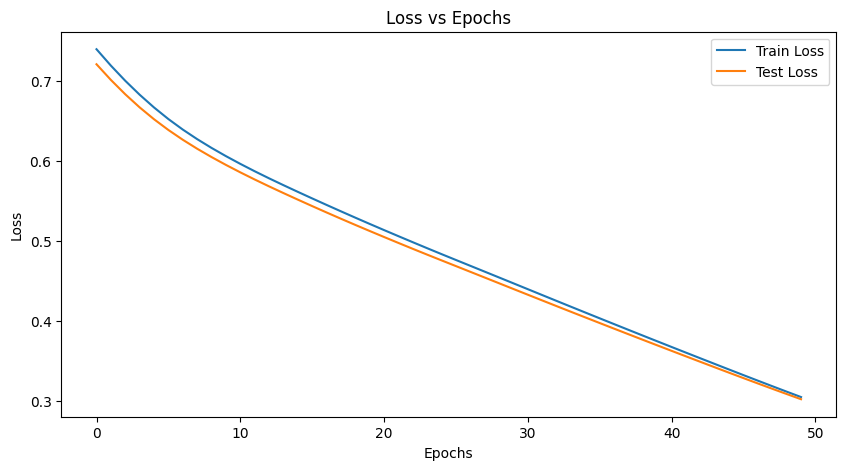

In [25]:
# Plot Loss vs Epochs
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epochs')
plt.show()

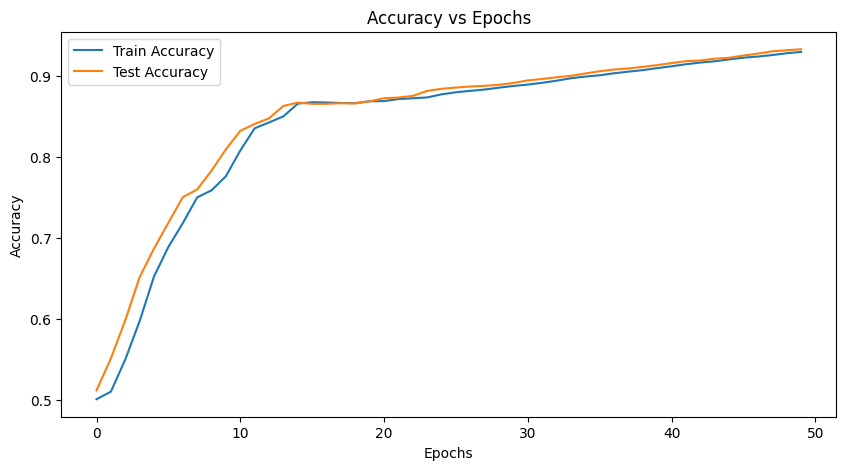

In [26]:
# Plot Accuracy vs Epochs
plt.figure(figsize=(10,5))
plt.plot(train_acc, label='Train Accuracy')
plt.plot(test_acc, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs Epochs')
plt.show()

In [28]:
# Ensure y_test is converted to a NumPy array
y_test_np = y_test_tensor.cpu().numpy()

# Compute Predictions
y_test_pred = torch.argmax(model(X_test_tensor), dim=1).cpu().numpy()

# Print Classification Report & Confusion Matrix
print("Classification Report:\n", classification_report(y_test_np, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test_np, y_test_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.89      0.93      1934
           1       0.90      0.98      0.94      1931

    accuracy                           0.93      3865
   macro avg       0.94      0.93      0.93      3865
weighted avg       0.94      0.93      0.93      3865

Confusion Matrix:
 [[1715  219]
 [  38 1893]]


In [29]:
# Apply Regularization (Dropout + L2)
class RegularizedModel(nn.Module):
    def __init__(self, input_dim, num_classes, hidden1=64, hidden2=32):
        super(RegularizedModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Linear(hidden2, num_classes)
        )
    
    def forward(self, x):
        return self.model(x)


In [30]:
# Train Regularized Model
regularized_model = RegularizedModel(input_dim, num_classes).to(device)
optimizer = optim.Adam(regularized_model.parameters(), lr=0.001, weight_decay=1e-4)
train_losses_reg, test_losses_reg, train_acc_reg, test_acc_reg = train_model(regularized_model, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, criterion, optimizer)


Epoch [10/50], Train Loss: 0.5931, Test Loss: 0.5823, Train Acc: 0.6026, Test Acc: 0.6225
Epoch [20/50], Train Loss: 0.5128, Test Loss: 0.5075, Train Acc: 0.7791, Test Acc: 0.7938
Epoch [30/50], Train Loss: 0.4382, Test Loss: 0.4322, Train Acc: 0.8947, Test Acc: 0.9022
Epoch [40/50], Train Loss: 0.3592, Test Loss: 0.3569, Train Acc: 0.9396, Test Acc: 0.9408
Epoch [50/50], Train Loss: 0.2823, Test Loss: 0.2796, Train Acc: 0.9587, Test Acc: 0.9656


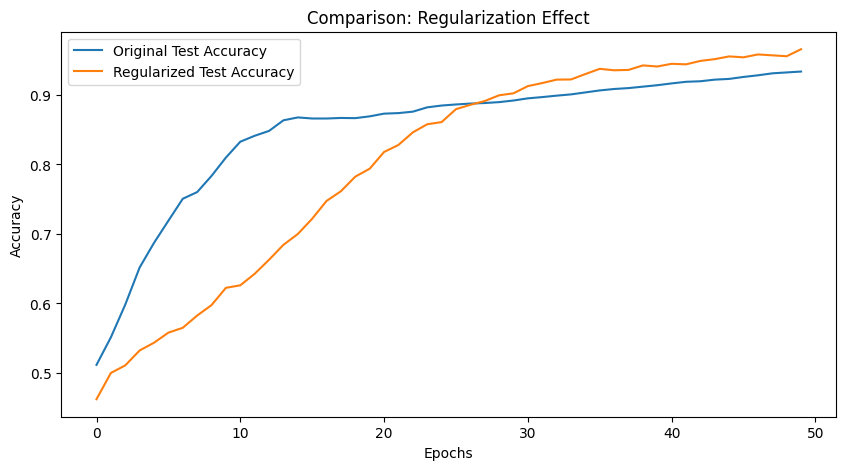

In [31]:
# Compare Regularization Effects
plt.figure(figsize=(10,5))
plt.plot(test_acc, label='Original Test Accuracy')
plt.plot(test_acc_reg, label='Regularized Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Comparison: Regularization Effect')
plt.show()
